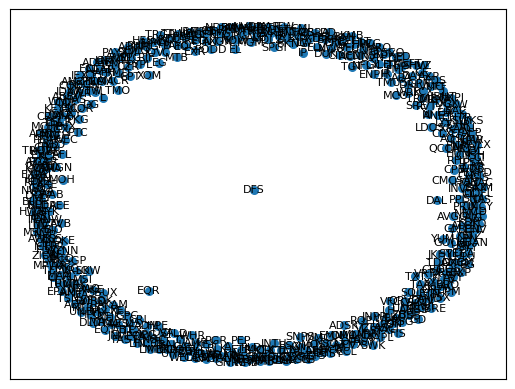

In [4]:
import pandas as pd 
import yfinance as yf 
from scipy.stats import spearmanr
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt 

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

#read wikipedia S&P500 table into PD dataframe 
df_sp500 = pd.read_html(url)[0][['Symbol', 'Security', 'GICS Sector']] 
#ticker DF 
sp500_tickers = df_sp500['Symbol'].tolist() 

#read changes table into DF 
#sp500_changes = pd.read_html(url)[1]
#problematic 
# drop rows where at least one element missing
#changes = df_changes[['Date', 'Added', 'Removed']].dropna() 
#filter out reasons column 
#changes = changes[~changes['Date'].str.contains('Reason')]
#filter out note column 
#changes = changes[~changes['Date'].str.contains('Note')] 

#leaving these fuckers out (Berkshire Hathaway - 2010, Brown-Forman - 1982, AirBNB - 2023....so on)
#issues: these have not been in the dataset for the full time period (1258 days) so i need to leave them out until ifigure something out 
exclude = ['BRK.B', 'BF.B', 'ABNB', 'CARR', 'CEG', 'CTVA', 'DOW', 'FOXA', 'FOX', 'GEHC', 'KVUE', 'OTIS', 'UBER', 'VLTO'] 
sp500_tickers = [ticker for ticker in sp500_tickers if ticker not in exclude]

#dict for individual stock DF storage 
stockdataframes = {} 

start_dte = "2019-01-01"
end_dte = "2023-12-31"

#ADD INCLUSION AND EXCLUSION DATE AND FILTER BY THAT FOR NEWER STOCKS AND REMOVED ONES 

#iterate through all tickers+ get historical data 
for ticker in sp500_tickers: 
    #added = row['Added'] 
    #removed = row['Removed'] 
    
    try:
        stock = yf.Ticker(ticker) 
        stock_df = stock.history(start=start_dte, end=end_dte)[['Close']]
        
        #debug 
        #print(f"Debug - Ticker: {ticker}, DataFrame shape: {stock_df.shape}")
        
        #merge with wiki data - check if not empty first
        if 'Close' in stock_df.columns and not stock_df.empty: 
            stock_df['Symbol'] = ticker
            stock_df['Security'] = df_sp500[df_sp500['Symbol'] == ticker]['Security'].iloc[0]
            stock_df['GICS Sector'] = df_sp500[df_sp500['Symbol'] == ticker]['GICS Sector'].iloc[0]
            #merged_stock_df = pd.merge(stock_df, df_sp500[df_sp500['Symbol'] == ticker], left_index=True, right_index=True)
        
            #store merged df in dictionary 
            stockdataframes[ticker] = stock_df #used o be merged_stock_dataframe
        
            #print(f"Data fetched for {ticker}")
        else:
            print(f"Failed to fetch data for {ticker}: {e}")
    except Exception as e: 
        print(f"Failed to fetch data for {ticker}: {e}")

#merge all stock dfs into one 
full_df = pd.concat(stockdataframes.values(), keys=stockdataframes.keys())

full_df = full_df.reset_index(level=0) 

monthly_df = full_df.resample('M').last() 

# Calculate Spearman correlation coefficient
corr_matrix = monthly_df.pivot(columns='Symbol', values='Close').pct_change().corr(method='spearman').dropna()

#create graph 
G = nx.Graph() 

for stock in sp500_tickers: 
    G.add_node(stock) 
    
#add links 
for i in range(len(sp500_tickers)): 
    for j in range(i + 1, len(sp500_tickers)):
        stock1 = sp500_tickers[i]
        stock2 = sp500_tickers[j]
        
        # Check if the stock symbols are present in the correlation matrix
        if stock1 in corr_matrix.index and stock2 in corr_matrix.columns:
            correlation_coefficient = corr_matrix.loc[stock1, stock2]
            if not np.isnan(correlation_coefficient):
                G.add_edge(stock1, stock2, weight=correlation_coefficient)

#visualization 
pos = nx.spring_layout(G, seed=42)
# Draw only edges with significant correlation
edges = [(source, target) for source, target, data in G.edges(data=True) if abs(data['weight']) > 0.5]
nx.draw_networkx_nodes(G, pos, node_size=30)
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='gray')

labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show() #its a bullshit hgraph and idk if the coefficient is actually doing anything  useful here


2

In [ ]:
#REF 
#import pandas as pd 
#import yfinance as yf 

#url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

#read tables into PD dataframe 
#dfs = pd.read_html(url) 

#get first table (index 0) + first 3 cols 
#df = dfs[0].iloc[:, :3] 
#print(df) 